In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
va_horse = np.load('../../../../data/commaai/calibration/cpl_dens/va_horse_cdf_is.npy')
hmc_horse = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_horse_cdf_is.npy')
va_ridge = np.load('../../../../data/commaai/calibration/cpl_dens/va_ridge_cdf_is.npy')
hmc_ridge = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_ridge_cdf_is.npy')

In [6]:
true_y = np.load('../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')
#true_y = true_y[np.abs(true_y) < 50]
density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)
grid = np.linspace(min(density['axes']), max(density['axes']), 750)

In [7]:
alphas = np.append(np.linspace(0.05, 0.95, 10), float(0.99))

In [10]:
def confidence_intervals(alphas, cdf_is, true_y, grid):
    all_conf_int = []
    for alpha2 in tqdm(alphas):
        confidence_intervals = []
        alpha = 1- alpha2
        i = 0
        for cdf in cdf_is:
            lb = max(grid[cdf <= alpha/2])
            try:
                ub = min(grid[cdf >= 1-alpha/2])
            except: 
                print('error at index:' + str(i))
                ub = max(support)
            i += 1
            confidence_intervals.append([lb, ub])
        all_conf_int.append(confidence_intervals)
    
    # prediction interval width
    conf_widths = []
    for level in range(0, np.append(np.linspace(0.05, 0.95, 10), float(0.99)).shape[0]):  
        conf_width = np.array([all_conf_int[level][i][1] - all_conf_int[level][i][0] for i in range(0, len(cdf_is))])
        conf_widths.append(conf_width)
    
    coverage_rate = []
    # prediction interval coverage rate
    for i in range(0, np.append(np.linspace(0.05, 0.95, 10), float(0.99)).shape[0]):
        confidence_intervals = all_conf_int[i]
        in_interval = []
        # loop over single PI 
        for i in range(0, len(true_y)):
            conf_int = confidence_intervals[i]
            if conf_int[0] <= true_y[i] <= conf_int[1]:
                in_interval.append(1)
            else:
                in_interval.append(0)
        mean_int = np.mean(in_interval)
        coverage_rate.append(mean_int)
    
    return({'prediction_intervals': all_conf_int,
            'pred_int_width': conf_widths, 
            'coverage_rate': coverage_rate})

In [11]:
va_horse_ci = confidence_intervals(alphas, va_horse, true_y, grid)
hmc_horse_ci = confidence_intervals(alphas, hmc_horse, true_y, grid)
va_ridge_ci = confidence_intervals(alphas, va_ridge, true_y, grid)
hmc_ridge_ci = confidence_intervals(alphas, hmc_ridge, true_y, grid)

100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


## Prediction Interval Coverage Rates

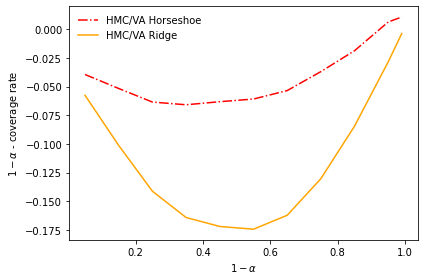

In [15]:
levels = np.append(np.linspace(0.05, 0.95, 10), float(0.99))
plt.plot(levels, levels - np.array(va_horse_ci['coverage_rate']), linestyle = '-.', label = 'HMC/VA Horseshoe', color = 'red')
#plt.plot(levels, levels - np.array(hmc_horse_ci['coverage_rate']), linestyle = 'dotted', label = 'HMC/Horseshoe', color = 'darkred')
plt.plot(levels, levels - np.array(va_ridge_ci['coverage_rate']), label = 'HMC/VA Ridge', color = 'orange')
#plt.plot(levels, levels - np.array(hmc_ridge_ci['coverage_rate']), label = 'HMC/Ridge', color = 'darkorange')
plt.xlabel((r'$1- \alpha$'))
plt.ylabel(r'$1- \alpha$ - coverage rate')
plt.legend()
plt.legend(framealpha=0.0)
plt.tight_layout()
plt.savefig('coverage_rate_cpl.png', dpi = 600)
# coverage rate is actually higher than predicted coverage rate

## PI width

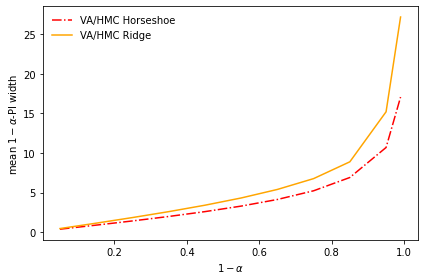

In [16]:
plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(va_horse_ci['pred_int_width'])), axis = 1), label = 'VA/HMC Horseshoe', color = 'red', linestyle = '-.')
#plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(hmc_horse_ci['pred_int_width'])), axis = 1), label = 'HMC/Horseshoe', linestyle = 'dotted',color = 'darkred')
plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(va_ridge_ci['pred_int_width'])), axis = 1), label = 'VA/HMC Ridge',  color = 'orange')
#plt.plot(np.append(np.linspace(0.05, 0.95, 10), float(0.99)), np.mean(np.abs(np.array(hmc_ridge_ci['pred_int_width'])), axis = 1), label = 'HMC/Ridge', color = 'darkorange')
plt.xlabel((r'$1- \alpha$'))
plt.ylabel(r'mean $1 - \alpha$-PI width')
plt.legend()
plt.legend(framealpha=0.0)
plt.tight_layout()
plt.savefig('mean_pi_width_cpl.png', dpi = 600)